<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Multiclass Classification using Deep Convolutional Neural Network </h1> 



<h3>Objective for this Notebook<h3>    
<h5> To demonstrate ability to use PyTorch to do transfer learning using a Deep Convolutional Neural Network to perform multiclass classification with accuracy greater than 85%. The ResNet18 will be used to classified the MNIST's Fashion dataset. </h5>     



<h2>Table of Contents</h2>
<b>This lab takes a long time to run so the results are given. You can run the notebook your self but it may take a long time.</b>
<p>In this lab, we will compare a Convolutional Neural Network using Batch Normalization with a regular Convolutional Neural Network  to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process. </p>

<ul>
    <li><a href="#read_me">Read me Batch Norm for Convolution Operation  </a></li>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Two Types of Convolutional Neural Network</a></li>
<li><a href="#Train">Define Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2 id="read_me">Read me Batch Norm for Convolution Operation  </h2>


Like a fully connected network, we create a <code>BatchNorm2d</code> object, but we apply it to the 2D convolution object. First, we create objects <code>Conv2d</code> object; we require the number of output channels, specified by the variable <code>OUT</code>.  


<code>self.cnn1 = nn.Conv2d(in_channels=1, out_channels=OUT, kernel_size=5, padding=2) </code>


We then create a Batch Norm  object for 2D convolution as follows:


<code>self.conv1_bn = nn.BatchNorm2d(OUT)</code>


The parameter out is the number of channels in the output. We can then apply batch norm  after  the convolution operation :


<code>x = self.cnn1(x)</code>
<p></p>
 <code> x=self.conv1_bn(x)</code>


<!--Empty Space for separating topics-->


<h2>Preparation</h2>


In [1]:
%%bash 
cat requirements.txt
pip install -qUr requirements.txt

pandas
numpy
matplotlib
scikit-learn
torch
torchvision

In [1]:
# Import the necessary libraries 
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
def show_data(data_sample):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle("50 Fashion MNIST Images", fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(data_sample.data, axes):
        ax.imshow(img, cmap='gray')
        #ax.title(f'{y}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<h2 id="Makeup_Data">Get the Data</h2> 


we create a transform to resize the image and convert it to a tensor :


In [33]:

IMAGE_SIZE = 16

composed = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.


In [34]:

train_dataset = dsets.FashionMNIST(root='./projectdata', train=True, download=True, transform=composed)

Load the testing dataset by setting the parameters train  <code>False</code>.


In [35]:
# Make the validating 

validation_dataset = dsets.FashionMNIST(root='./projectdata', train=False, download=True, transform=composed)

We can see the data type is long.


In [36]:
# Show the data type for each element in dataset

train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [37]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [38]:
i = 0
while i<10:
    print(f'{train_dataset.classes[train_dataset.targets[i]]}')
    i+=1

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal


In [39]:
# The label for the fourth data element

validation_dataset.data.shape, validation_dataset.targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

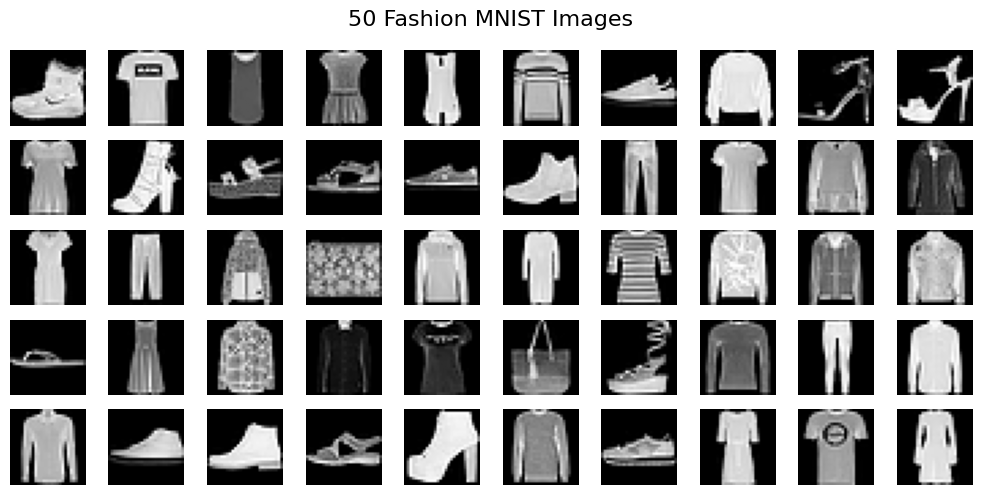

In [40]:
# The image for the fourth data element
show_data(train_dataset)

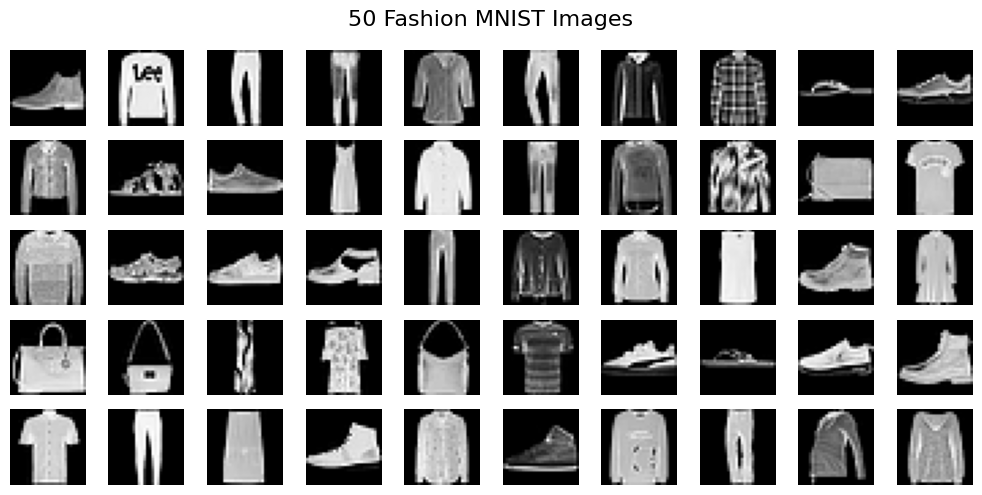

In [41]:
show_data(validation_dataset)

<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [42]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. But we add Batch Norm for the convolutional layers. 


In [50]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=28, out_2=56, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

Function to train the model 


In [44]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=10):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 


There are 16 output channels for the first layer, and 32 output channels for the second layer 


In [45]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

Define the loss function, the optimizer and the dataset loader 


In [46]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [47]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [48]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(
    model=model,n_epochs=10,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer)

Repeat the Process for the model with  batch norm 


In [51]:
model_batch=CNN_batch(out_1=32, out_2=64)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss with both networks.


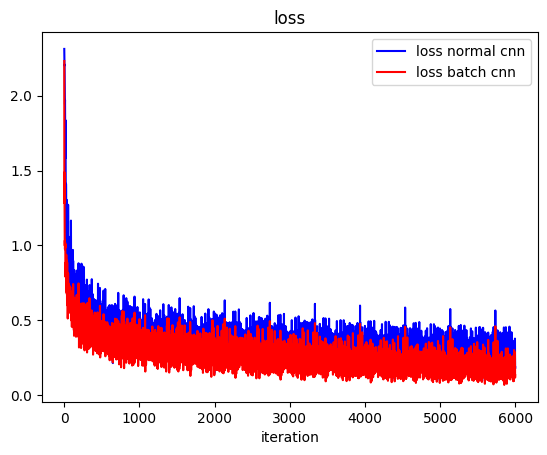

In [52]:
# Plot the loss and accuracy
plt.plot(loss_list_normal, 'b', label='loss normal cnn')
plt.plot(loss_list_batch, 'r', label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

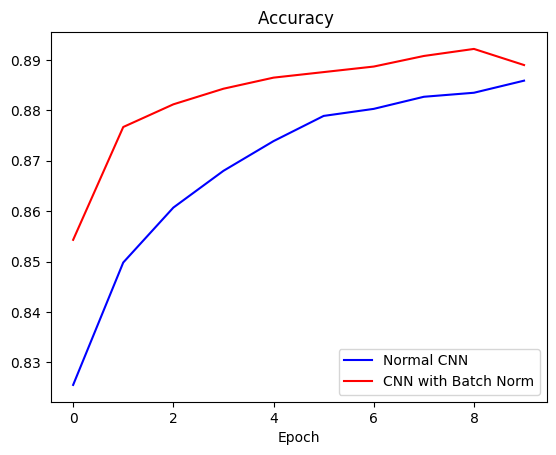

In [53]:
plt.plot(accuracy_list_normal, 'b', label='Normal CNN')
plt.plot(accuracy_list_batch, 'r', label='CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

We see the CNN with batch norm performers better, with faster convergence.



<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
